## Imports

In [17]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
import copy

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
from lime import lime_image

from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
%matplotlib inline
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Settings

In [18]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 15

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 16*torch.cuda.device_count()
GRAYSCALE = False

### Downloading the Dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

1) Download and unzip the file `img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `list_attr_celeba.txt` file, which contains the class labels

3) Download the `list_eval_partition.txt` file, which contains  training/validation/test partitioning info

### Preparing the Dataset

In [3]:
df1 = pd.read_csv('./celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [4]:
df2 = pd.read_csv('./celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [5]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [6]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [7]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


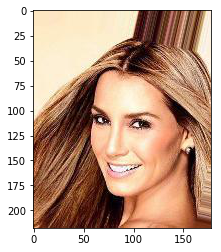

In [8]:
img = Image.open('./celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Implementing a Custom DataLoader Class

In [9]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [10]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='./celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='./celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='./celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [11]:
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        time.sleep(1)
        break

Epoch: 1 | Batch index: 0 | Batch size: 16
Epoch: 2 | Batch index: 0 | Batch size: 16


## Model

In [12]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}

# Training

In [50]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 0.0353 Acc: 0.9875
val Loss: 0.0452 Acc: 0.9839

Epoch 1/2
----------
train Loss: 0.0231 Acc: 0.9917
val Loss: 0.0438 Acc: 0.9852

Epoch 2/2
----------
train Loss: 0.0151 Acc: 0.9946
val Loss: 0.0428 Acc: 0.9870

Training complete in 49m 24s
Best val Acc: 0.986963


In [53]:
torch.save(model_ft.state_dict(), "./resnet_ft.pth")

# Pretrained

In [14]:
model_ft.load_state_dict(torch.load("./resnet_ft.pth"))

<All keys matched successfully>

## Evaluation

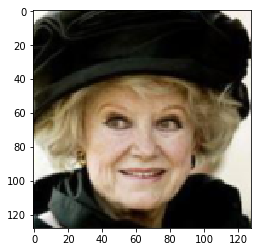

In [15]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [16]:
model_ft.eval()
x = model_ft(features.to(DEVICE)[0, None])
probas = F.softmax(x, dim=1)
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 100.00%


# Baseline test

In [19]:
mr2_baseline_data = pd.read_csv("../../dataset.csv")

In [20]:
y_pred = []

In [21]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [25]:
def run_baseline_pred(path):    
    img = get_image(path)
    transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                           transforms.Resize((128, 128)),
                           transforms.ToTensor()])
    img1 = transform(img)
    img1 = img1.unsqueeze(0)

    with torch.no_grad():
        x = model_ft(img1.to(DEVICE))
        pred_scores = F.softmax(x, dim=1)
        return pred_scores

In [26]:
for name in mr2_baseline_data.name:
    res = run_baseline_pred("../../MR2 faces/"+name+".tif")
    if res[0][0] > res[0][1]:
        y_pred.append("Female")
    else:
        y_pred.append("Male")
mr2_baseline_data["Baseline Prediction"] = y_pred

In [30]:
mr2_baseline_data["Flagged"] = [False]*mr2_baseline_data.shape[0]

In [31]:
mr2_baseline_data.loc[(mr2_baseline_data["sex"] != mr2_baseline_data["Baseline Prediction"]), "Flagged"] = True

In [37]:
mr2_baseline_data[mr2_baseline_data["Flagged"] == True]

,name,race,sex,Baseline Prediction,Flagged
0,wf03,European,Female,Male,True
1,af07,Asian,Female,Male,True
4,af12,Asian,Female,Male,True
5,af06,Asian,Female,Male,True
6,wf02,European,Female,Male,True
7,af10,Asian,Female,Male,True
8,af04,Asian,Female,Male,True
12,af11,Asian,Female,Male,True
13,wf01,European,Female,Male,True
14,wf11,European,Female,Male,True
